In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# CNN


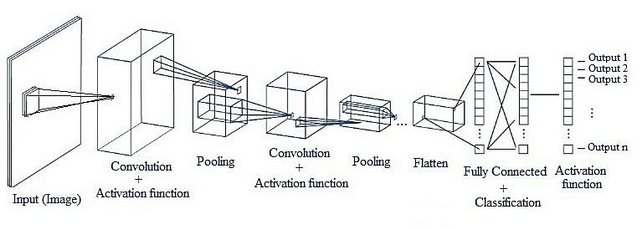

* CNN stands for Convolutional Neural Network, and is a technique for classifying images by applying filtering techniques to artificial neural networks.(CNN은 Convolutional Neural Network의 약자로, 필터링 기법을 인공 신경망에 적용하여 이미지를 분류하는 기법이다.)
* The black and white image is made of two-dimensional data and has a value between 0 and 255.(흑백 이미지는 2차원의 데이터로 되어있고, 0~255 사이의 값으로 되어있다.)
* By receiving the image raw input, it builds up the hierarchy of features while maintaining spatial and regional information. CNN's key points are to look at the part rather than the whole image, and to make use of the connection between one pixel and the surrounding pixels of the image. (이미지를 날것(raw input) 그대로 받음으로써 공간적/지역적 정보를 유지한 채 특성(feature)들의 계층을 빌드업한다. CNN의 중요 포인트는 이미지 전체보다는 부분을 보는 것, 그리고 이미지의 한 픽셀과 주변 픽셀들의 연관성을 살리는 것이다.)


# 1. Loading the dataset

In [ ]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [ ]:
print(train.shape)
print(train.info())
train.head()

In [ ]:
print(test.shape)
print(test.info())
test.head()

In [ ]:
y_train = train["label"]

# drop "label" columns
x_train = train.drop(labels=["label"], axis = 1)

In [ ]:
plt.figure(figsize=(15,10))
g = sns.countplot(y_train, palette='Spectral')
plt.title("Number of digit classes")
y_train.value_counts()

In [ ]:
#standardization by dividing by 255(픽셀이 0~255의 정수 값을 갖기 때문에 255로 나누어 표준화)
x_train = x_train / 255.0 
test = test / 255.0
print("x_train shape", x_train.shape)
print("test shape", test.shape)

In [ ]:
# Transform dimension to CNN model input format (CNN 모델 입력 형태로 차원을 변환)
x_train = x_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)
print("x_train shape", x_train.shape)
print("test shape", test.shape)

In [ ]:
# Label Encoding (레이블 인코딩)
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes = 10)


# 2. Train, Test data split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size = 0.1, 
                                                  random_state = 5)

In [ ]:
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

In [ ]:
plt.imshow(X_train[1][:,:,0],cmap='gray')
plt.show()

In [ ]:
plt.imshow(X_train[0][:,:,0],cmap='gray')
plt.show()

# 3. Convolutional Neural Network (CNN)

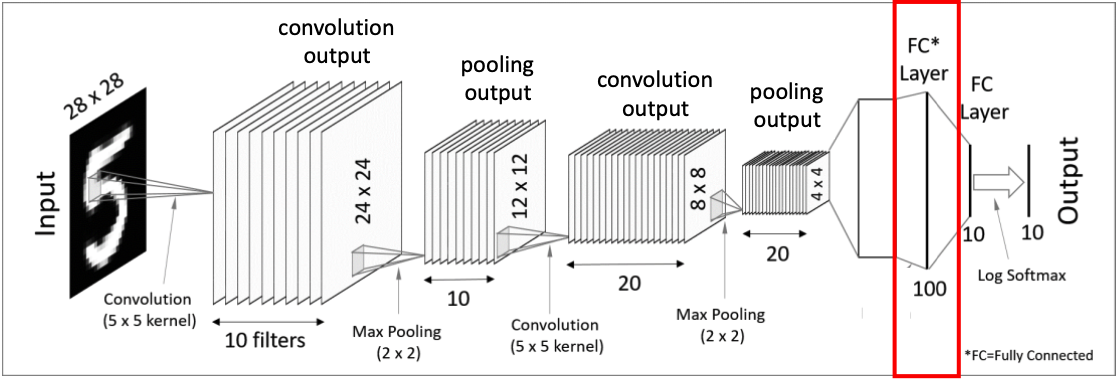

In [ ]:
import os
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


### 3.1 First Convolutional Layer
* The input value is an image with a size of 28x28 that uses multiple filters (kernels) to obtain the result value: 10 24x24 matrices result values are created using 10 5x5 filters for one 28x28 image.(입력값은 28x28크기를 가진 이미지, 이를 대상으로 여러개의 필터(커널)를 사용해 결과값을 얻는다: 한개의 28x28 이미지에 10개의 5x5 필터를 사용해 10개의 24x24 matrixs 결과값을 만든다.)
* Apply the Activation function to the derived result value (도출해낸 결과값에 Activation function(활성 함수)을 적용)
    * Activation function: 선형함수(linear function)인 convolution에 비선형성(nonlinearity)를 추가하기 위해 사용

In [ ]:
model = Sequential()

# 3.1 Conv2D layer(컨볼루션 레이어)
model.add(Conv2D(filters = 8, 
                 kernel_size = (5,5),
                 padding = 'Same', 
                 activation ='relu', 
                 input_shape = (28,28,1)))

### 3.2. First Pooling Layer
* Pooling aims to reduce the dimensionality of each feature map.(Pooling은 각 결과값(feature map)의 dimentionality를 축소해 주는 것을 목적으로 둔다.) 
* That is, the process of reducing the dimension of each result value by deleting the part with low correlation. (즉, correlation이 낮은 부분을 삭제하여 각 결과값을 크기(dimension)을 줄이는 과정이다.)
    * ex) Max pooling, Average pooling

In [ ]:
# 3.2 Maxpool2d layer
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

### 3.3 Second Convolutional Layer
* 20 5x5x10 sized tensor filters are used for the 12x12x10 tensor obtained from the previous pooling layer. (이전의 pooling layer에서 얻어낸 12x12x10 텐서(order-3 tensor)를 대상으로 5x5x10크기의 텐서필터 20개를 사용한다.) 
    * Twenty result values of 8x8 size each are obtained.(각각 8x8크기를 가진 결과값 20개를 얻어낸다.)

In [ ]:
# 3.3 Second convolutional layer 
model.add(Conv2D(filters = 16, 
                 kernel_size = (3,3),
                 padding = 'Same', 
                 activation ='relu'))

### 3.4 Second Pooling Layer
* By processing the pooling process in the same way as before, 20 smaller 4x4 results are obtained.(전과 똑같은 방식으로 Pooling과정을 처리해주어 더 크기가 작아진 20개의 4x4 결과값을 얻는다.)

In [ ]:
# 3.4 Second Pooling Layer 
model.add(MaxPool2D(pool_size=(2,2), 
                    strides=(2,2)))
model.add(Dropout(0.25))

### 3.5 Flatten(Vectorization)
* After that, this 4x4x20 tensor is spread out as straight data. In other words, each vertical line is placed in a line. (그 후, 이 4x4x20의 텐서를 일자 형태의 데이터로 쭉 펼쳐준다. 즉, 각 세로줄을 일렬로 쭉 세워둔다.)
* This becomes a vector form having 320-dimension. (이는 320-dimension을 가진 벡터(vector)형태가 된다.)

In [ ]:
# 3.5 Flatten
model.add(Flatten())

### 3.6 Fully-Connected Layers(Dense Layers)
* When one or more fully-connected layers are applied and the Softmax activation function is applied at the end, the final result is finally output. (하나 혹은 하나 이상의 Fully-Connected Layer를 적용시키고 마지막에 Softmax activation function을 적용해주면 드디어 최종 결과물을 출력하게 된다.)

In [ ]:
# 3.6 fully connected
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
model.summary()

### 3.7 imageDataGenerator: 이미지데이터 학습을 쉽게하기위한 클래스
* Pre-processing of data can be facilitated by transferring parameters when creating an object. (객체를 생성할 때 파라미터를 전달해주는 것을 통해 데이터의 전처리를 쉽게할 수 있다.)
* Data augmentation: 이를 이용해 데이터를 늘린 뒤 학습을 진행한다. 

In [ ]:
# Define the optimizer
optimizer = Adam(lr = 0.001,
                beta_1 = 0.9,
                beta_2 = 0.999)

In [ ]:
# data augmentation
# create a generator

datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # dimesion reduction
        rotation_range = 15,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.01, # Randomly zoom image 10%
        width_shift_range = 0.1,  # randomly shift images horizontally 10%
        height_shift_range = 0.1,  # randomly shift images vertically 10%
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(X_train)

### 3.8 Fit the model

In [ ]:
# create and compile models
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy", 
              metrics=["accuracy"])

#for better result increase the epochs
epochs = 100
batch_size = 250


# training
history = model.fit_generator(datagen.flow(X_train,
                                           Y_train, 
                                           batch_size = batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,Y_val), 
                              validation_steps = X_val.shape[0] // batch_size)

# 4. Model evaluation

### 4.1 Plot the loss and accuracy curves for training and validation 

In [ ]:
# plot 1: Loss
fig, ax = plt.subplots(2,1, figsize=(15, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# plot 2: accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.2 Confusion matrix

In [ ]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,cmap="coolwarm",
            linecolor="white", 
            fmt= '.1f',ax=ax)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 5. Prediction and Submission

### 5.1 Prediction validation results

In [ ]:
y_pred = model.predict(X_val)
X_test__ = X_val.reshape(X_val.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {Y_val[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## 5.2 Submission

In [ ]:
test.shape

In [ ]:
results = model.predict(test)
results = np.argmax(results,axis = 1)
submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [ ]:
submission['Label'] = results
submission.to_csv('submission.csv', header=True, index=False)

## 6. References
* I understood the cnn process from Irene Ban's posting. I would like to express my gratitude to her.
    1. https://halfundecided.medium.com/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-cnn-convolutional-neural-networks-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-836869f88375

    2. https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial
    
    3. https://colinch4.github.io/2020-12-04/ImageDataGenerator2/
    
    4. https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1

* I tried image processing using cnn for the first time. The process of reaching fully-connected layers through multiple layers was impressive. In addition, we tried to improve CNN using the imageDataGenerator class.